<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/src/SYN/focus/size_vs_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

Cloning into 'thesis'...
remote: Enumerating objects: 1775, done.
remote: Counting objects: 100% (502/502), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 1775 (delta 309), reused 474 (delta 293), pack-reused 1273
Receiving objects: 100% (1775/1775), 77.96 MiB | 7.62 MiB/s, done.
Resolving deltas: 100% (1130/1130), done.
Mounted at /content/drive


## Prepare Data

In [3]:
rd=pd.read_csv('/content/drive/MyDrive/thesis/data/reddit/reddit_PRO.csv')
fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')
vo=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_PRO.csv')
gb=pd.read_csv('/content/drive/MyDrive/thesis/data/gab/gab_PRO.csv')
h=100

fb=filter_first_h(fb,h)
gb=filter_first_h(gb,h)
rd=filter_first_h(rd,h)
vo=filter_first_h(vo,h)

names = ['gb','rd','fb','vo']
gb['social']='Gab'
datas = [gb,rd,fb,vo]

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


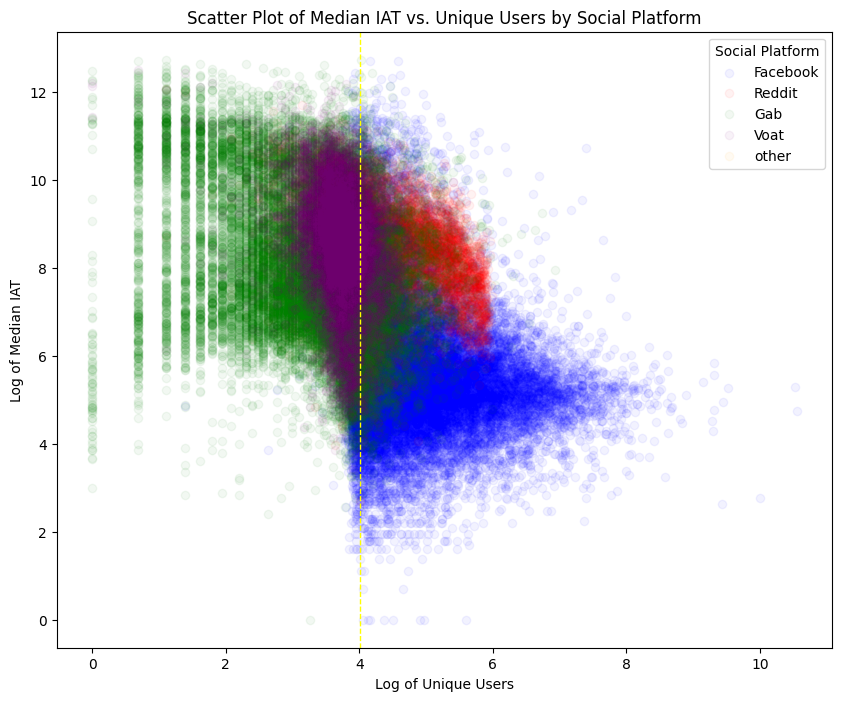

In [4]:
df = pd.concat(datas)
# Calculate the median of 'IAT_user_thread' per 'post_id' and 'user_id'
median_IAT = df.groupby(['post_id', 'user_id'])['IAT_user_thread'].max().reset_index()
median_IAT = median_IAT.groupby('post_id')['IAT_user_thread'].median().reset_index()
median_IAT.columns = ['post_id', 'Median_IAT']

# Calculate the number of unique 'user_id' per 'post_id'
unique_users = df.groupby('post_id')['user_id'].nunique().reset_index()
unique_users.columns = ['post_id', 'Unique_Users']

# Merge the two resulting DataFrames
merged = pd.merge(median_IAT, unique_users, on='post_id')

# Merge with the social column
social_data = df[['post_id', 'social']].drop_duplicates()
merged = pd.merge(merged, social_data, on='post_id')

# Create a scatter plot
plt.figure(figsize=(10, 8))

# Map social platforms to colors
colors = {'Facebook': 'blue', 'Reddit': 'red', 'Gab': 'green', 'Voat': 'purple', 'other': 'orange'}

for social, color in colors.items():
    subset = merged[merged['social'] == social]
    plt.scatter(np.log(subset['Unique_Users']), np.log(subset['Median_IAT']), color=color, label=social, alpha=0.05, marker='o')
plt.axvline(x=np.log(55), color='yellow', linestyle='--', linewidth=1)
plt.title('Scatter Plot of Median IAT vs. Unique Users by Social Platform')
plt.xlabel('Log of Unique Users')
plt.ylabel('Log of Median IAT')
plt.legend(title='Social Platform')
plt.show()




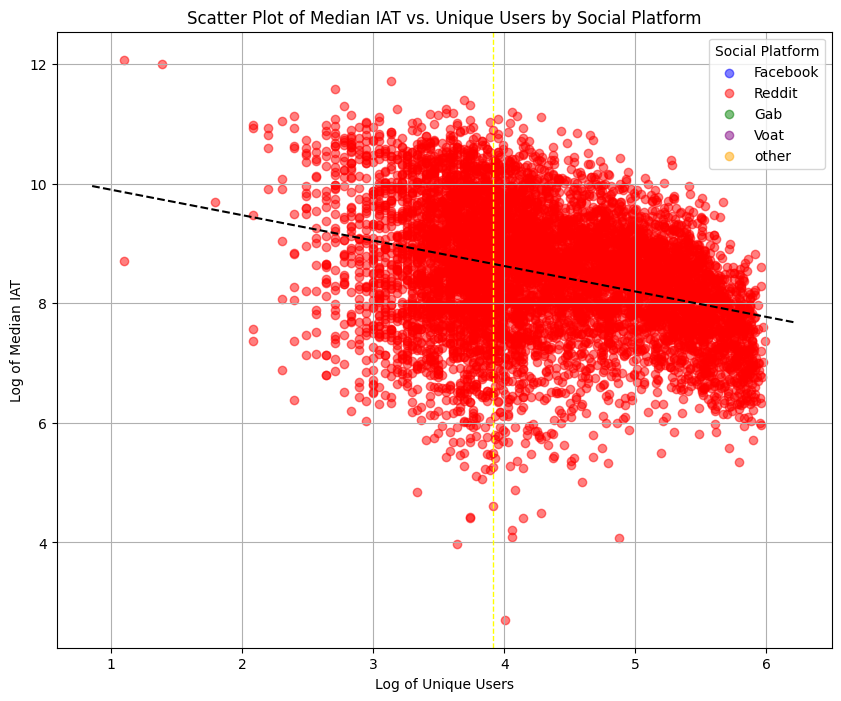

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Concatenate the data
df = rd#pd.concat(datas)

# Calculate the median of 'IAT_user_thread' per 'post_id' and 'user_id'
median_IAT = df.groupby(['post_id', 'user_id'])['IAT_user_thread'].max().reset_index()
median_IAT = median_IAT.groupby('post_id')['IAT_user_thread'].median().reset_index()
median_IAT.columns = ['post_id', 'Median_IAT']

# Calculate the number of unique 'user_id' per 'post_id'
unique_users = df.groupby('post_id')['user_id'].nunique().reset_index()
unique_users.columns = ['post_id', 'Unique_Users']

# Merge the two resulting DataFrames
merged = pd.merge(median_IAT, unique_users, on='post_id')

# Merge with the social column
social_data = df[['post_id', 'social']].drop_duplicates()
merged = pd.merge(merged, social_data, on='post_id')

# Log-transform the data
merged['Log_Unique_Users'] = np.log(merged['Unique_Users'])
merged['Log_Median_IAT'] = np.log(merged['Median_IAT'])

# Prepare data for linear regression
X = merged[['Log_Unique_Users']].values
y = merged['Log_Median_IAT'].values

# Fit the linear regression model
reg = LinearRegression().fit(X, y)

# Create a scatter plot
plt.figure(figsize=(10, 8))

# Map social platforms to colors
colors = {'Facebook': 'blue', 'Reddit': 'red', 'Gab': 'green', 'Voat': 'purple', 'other': 'orange'}

for social, color in colors.items():
    subset = merged[merged['social'] == social]
    plt.scatter(subset['Log_Unique_Users'], subset['Log_Median_IAT'], color=color, label=social, alpha=0.5, marker='o')

# Plot the regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = reg.intercept_ + reg.coef_ * x_vals
plt.plot(x_vals, y_vals, '--', color='black')

# Add a vertical line at log(55)
plt.axvline(x=np.log(50), color='yellow', linestyle='--', linewidth=1)

plt.title('Scatter Plot of Median IAT vs. Unique Users by Social Platform')
plt.xlabel('Log of Unique Users')
plt.ylabel('Log of Median IAT')
plt.legend(title='Social Platform')
plt.grid(True)
plt.show()


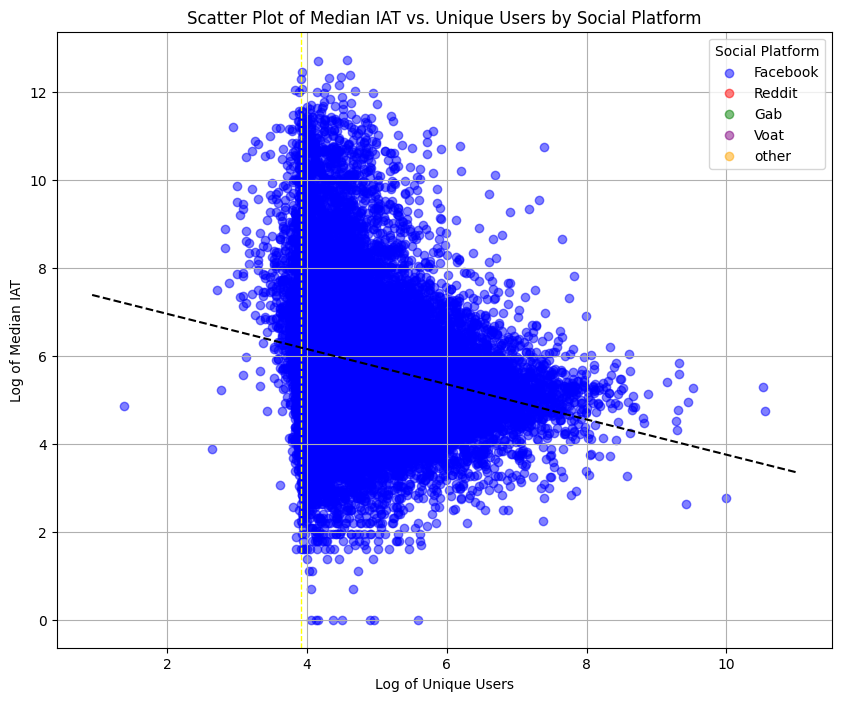

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Concatenate the data
df = fb#pd.concat(datas)

# Calculate the median of 'IAT_user_thread' per 'post_id' and 'user_id'
median_IAT = df.groupby(['post_id', 'user_id'])['IAT_user_thread'].max().reset_index()
median_IAT = median_IAT.groupby('post_id')['IAT_user_thread'].median().reset_index()
median_IAT.columns = ['post_id', 'Median_IAT']

# Calculate the number of unique 'user_id' per 'post_id'
unique_users = df.groupby('post_id')['user_id'].nunique().reset_index()
unique_users.columns = ['post_id', 'Unique_Users']

# Merge the two resulting DataFrames
merged = pd.merge(median_IAT, unique_users, on='post_id')

# Merge with the social column
social_data = df[['post_id', 'social']].drop_duplicates()
merged = pd.merge(merged, social_data, on='post_id')


# Log-transform the data
merged['Log_Unique_Users'] = np.log(merged['Unique_Users'])
merged['Log_Median_IAT'] = np.log(merged['Median_IAT'])

# Prepare data for linear regression
merged = merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['Log_Unique_Users', 'Log_Median_IAT'])
X = merged[['Log_Unique_Users']].values
y = merged['Log_Median_IAT'].values

# Fit the linear regression model
reg = LinearRegression().fit(X, y)

# Create a scatter plot
plt.figure(figsize=(10, 8))

# Map social platforms to colors
colors = {'Facebook': 'blue', 'Reddit': 'red', 'Gab': 'green', 'Voat': 'purple', 'other': 'orange'}

for social, color in colors.items():
    subset = merged[merged['social'] == social]
    plt.scatter(subset['Log_Unique_Users'], subset['Log_Median_IAT'], color=color, label=social, alpha=0.5, marker='o')

# Plot the regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = reg.intercept_ + reg.coef_ * x_vals
plt.plot(x_vals, y_vals, '--', color='black')

# Add a vertical line at log(55)
plt.axvline(x=np.log(50), color='yellow', linestyle='--', linewidth=1)

plt.title('Scatter Plot of Median IAT vs. Unique Users by Social Platform')
plt.xlabel('Log of Unique Users')
plt.ylabel('Log of Median IAT')
plt.legend(title='Social Platform')
plt.grid(True)
plt.show()


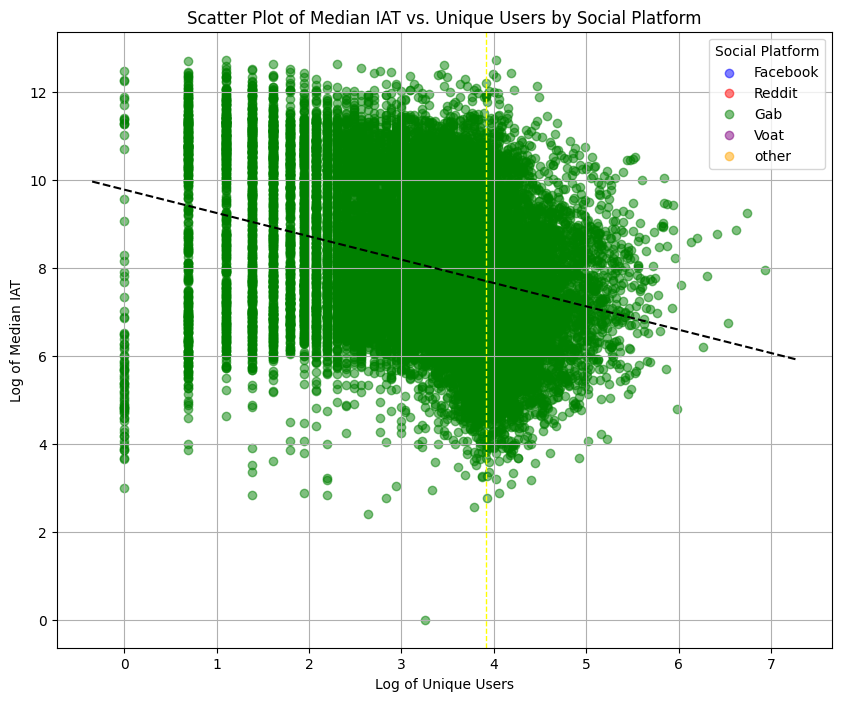

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Concatenate the data
df = gb#pd.concat(datas)

# Calculate the median of 'IAT_user_thread' per 'post_id' and 'user_id'
median_IAT = df.groupby(['post_id', 'user_id'])['IAT_user_thread'].max().reset_index()
median_IAT = median_IAT.groupby('post_id')['IAT_user_thread'].median().reset_index()
median_IAT.columns = ['post_id', 'Median_IAT']

# Calculate the number of unique 'user_id' per 'post_id'
unique_users = df.groupby('post_id')['user_id'].nunique().reset_index()
unique_users.columns = ['post_id', 'Unique_Users']

# Merge the two resulting DataFrames
merged = pd.merge(median_IAT, unique_users, on='post_id')

# Merge with the social column
social_data = df[['post_id', 'social']].drop_duplicates()
merged = pd.merge(merged, social_data, on='post_id')


# Log-transform the data
merged['Log_Unique_Users'] = np.log(merged['Unique_Users'])
merged['Log_Median_IAT'] = np.log(merged['Median_IAT'])

# Prepare data for linear regression
merged = merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['Log_Unique_Users', 'Log_Median_IAT'])
X = merged[['Log_Unique_Users']].values
y = merged['Log_Median_IAT'].values

# Fit the linear regression model
reg = LinearRegression().fit(X, y)

# Create a scatter plot
plt.figure(figsize=(10, 8))

# Map social platforms to colors
colors = {'Facebook': 'blue', 'Reddit': 'red', 'Gab': 'green', 'Voat': 'purple', 'other': 'orange'}

for social, color in colors.items():
    subset = merged[merged['social'] == social]
    plt.scatter(subset['Log_Unique_Users'], subset['Log_Median_IAT'], color=color, label=social, alpha=0.5, marker='o')

# Plot the regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = reg.intercept_ + reg.coef_ * x_vals
plt.plot(x_vals, y_vals, '--', color='black')

# Add a vertical line at log(55)
plt.axvline(x=np.log(50), color='yellow', linestyle='--', linewidth=1)

plt.title('Scatter Plot of Median IAT vs. Unique Users by Social Platform')
plt.xlabel('Log of Unique Users')
plt.ylabel('Log of Median IAT')
plt.legend(title='Social Platform')
plt.grid(True)
plt.show()


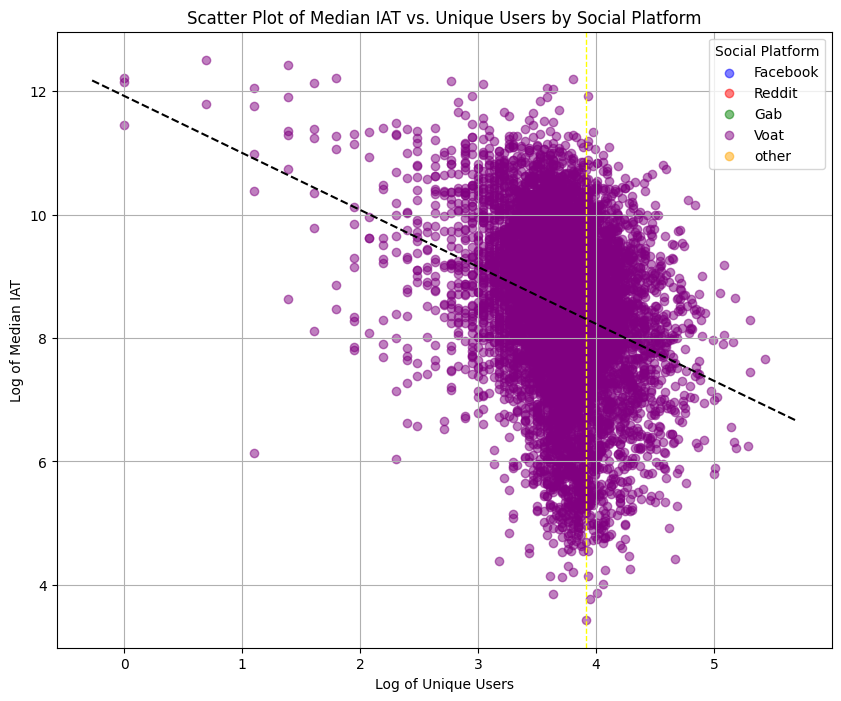

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Concatenate the data
df = vo#pd.concat(datas)

# Calculate the median of 'IAT_user_thread' per 'post_id' and 'user_id'
median_IAT = df.groupby(['post_id', 'user_id'])['IAT_user_thread'].max().reset_index()
median_IAT = median_IAT.groupby('post_id')['IAT_user_thread'].median().reset_index()
median_IAT.columns = ['post_id', 'Median_IAT']

# Calculate the number of unique 'user_id' per 'post_id'
unique_users = df.groupby('post_id')['user_id'].nunique().reset_index()
unique_users.columns = ['post_id', 'Unique_Users']

# Merge the two resulting DataFrames
merged = pd.merge(median_IAT, unique_users, on='post_id')

# Merge with the social column
social_data = df[['post_id', 'social']].drop_duplicates()
merged = pd.merge(merged, social_data, on='post_id')


# Log-transform the data
merged['Log_Unique_Users'] = np.log(merged['Unique_Users'])
merged['Log_Median_IAT'] = np.log(merged['Median_IAT'])

# Prepare data for linear regression
merged = merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['Log_Unique_Users', 'Log_Median_IAT'])
X = merged[['Log_Unique_Users']].values
y = merged['Log_Median_IAT'].values

# Fit the linear regression model
reg = LinearRegression().fit(X, y)

# Create a scatter plot
plt.figure(figsize=(10, 8))

# Map social platforms to colors
colors = {'Facebook': 'blue', 'Reddit': 'red', 'Gab': 'green', 'Voat': 'purple', 'other': 'orange'}

for social, color in colors.items():
    subset = merged[merged['social'] == social]
    plt.scatter(subset['Log_Unique_Users'], subset['Log_Median_IAT'], color=color, label=social, alpha=0.5, marker='o')

# Plot the regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = reg.intercept_ + reg.coef_ * x_vals
plt.plot(x_vals, y_vals, '--', color='black')

# Add a vertical line at log(55)
plt.axvline(x=np.log(50), color='yellow', linestyle='--', linewidth=1)

plt.title('Scatter Plot of Median IAT vs. Unique Users by Social Platform')
plt.xlabel('Log of Unique Users')
plt.ylabel('Log of Median IAT')
plt.legend(title='Social Platform')
plt.grid(True)
plt.show()


In [48]:

def prepare_data(df):
    df['IAT_user_thread'] = df['IAT_user_thread'].fillna(0)
    median_IAT = df.groupby(['post_id', 'user_id'])['IAT_user_thread'].count().reset_index()
    median_IAT = median_IAT.groupby('post_id')['IAT_user_thread'].median().reset_index()
    median_IAT.columns = ['post_id', 'Median_IAT']

    unique_users = df.groupby('post_id')['user_id'].nunique().reset_index()
    unique_users.columns = ['post_id', 'Unique_Users']

    merged = pd.merge(median_IAT, unique_users, on='post_id')

    social_data = df[['post_id', 'social']].drop_duplicates()
    merged = pd.merge(merged, social_data, on='post_id')

    merged['Log_Unique_Users'] = np.log(merged['Unique_Users'])
    merged['Log_Median_IAT'] = np.log(merged['Median_IAT'])

    merged = merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['Log_Unique_Users', 'Log_Median_IAT'])
    merged=merged[merged['Log_Unique_Users']>4]
    return merged

# Prepare data for each platform
rd_data = prepare_data(rd)
vo_data = prepare_data(vo)
fb_data = prepare_data(fb)
gb_data = prepare_data(gb)

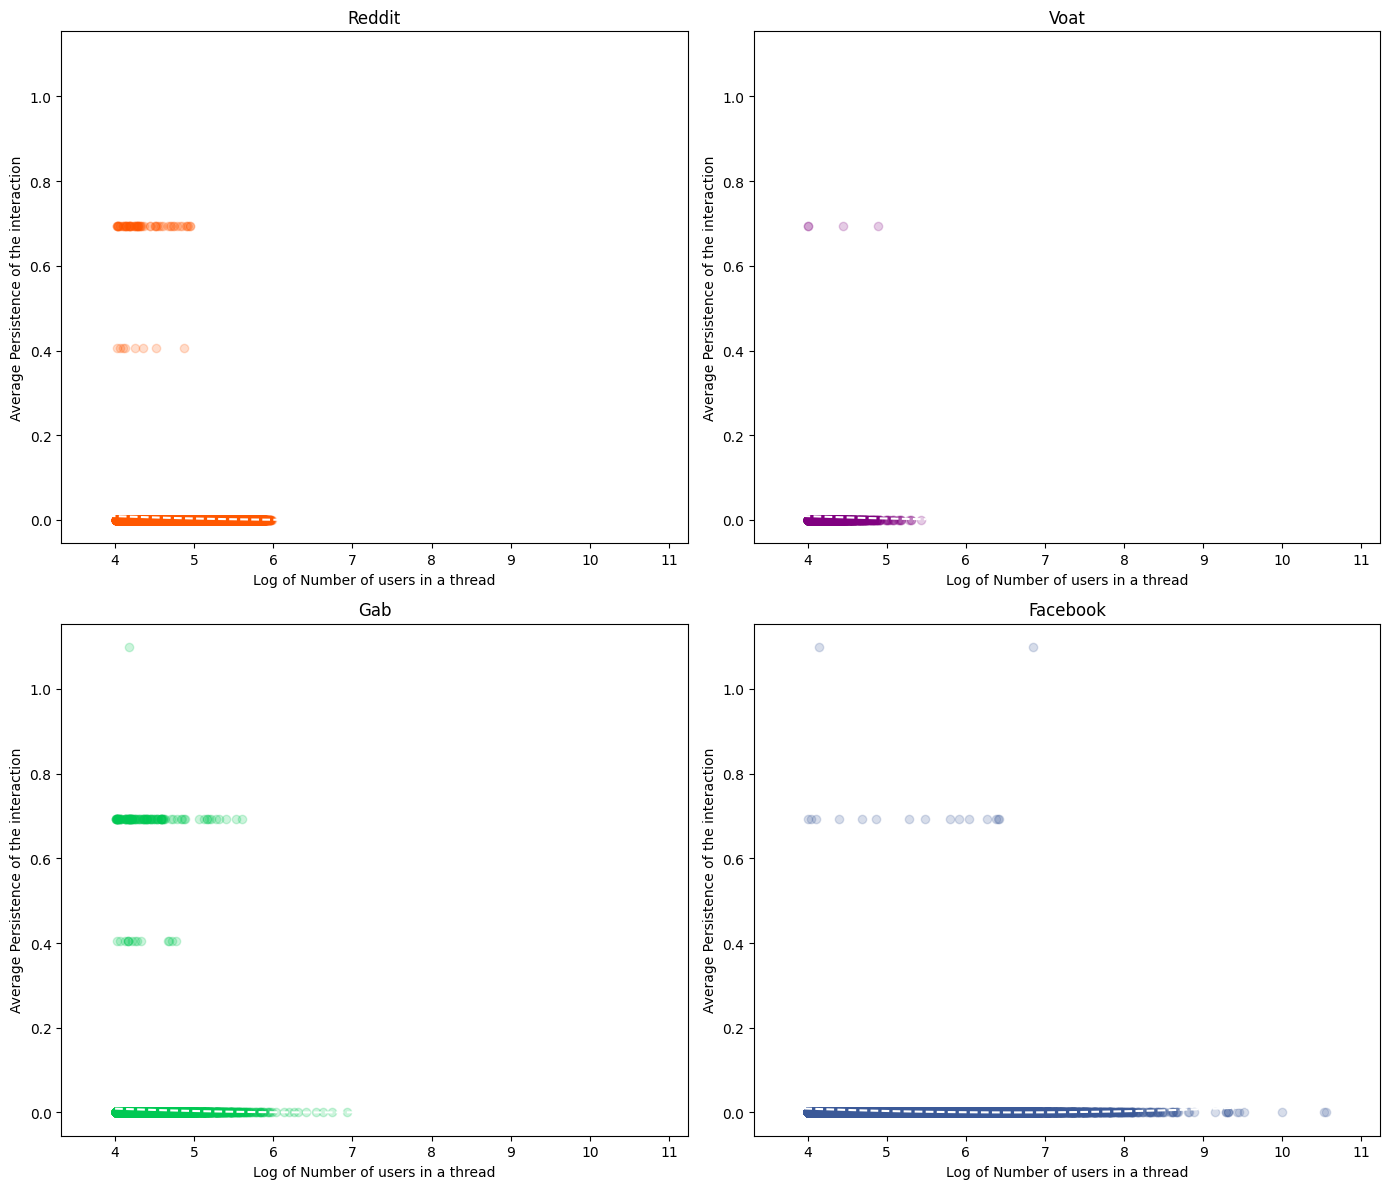

In [49]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming rd_data, vo_data, fb_data, gb_data are your DataFrames for each platform
# Concatenate the data into one DataFrame
all_data = pd.concat([rd_data, vo_data, fb_data, gb_data])

# Extract X (independent variable) and y (dependent variable)
X = all_data[['Log_Unique_Users']].values
y = all_data['Log_Median_IAT'].values

# Fit a polynomial of degree 2
coefficients = np.polyfit(X.flatten(), y, 2)
poly = np.poly1d(coefficients)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

platforms = {'Reddit': rd_data, 'Voat': vo_data, 'Gab': gb_data, 'Facebook': fb_data}
for ax, (platform, data) in zip(axs.ravel(), platforms.items()):
    ax.scatter(data['Log_Unique_Users'], data['Log_Median_IAT'], color=colors[platform], label=platform, alpha=0.2, marker='o')

    # Plot the polynomial curve
    x_vals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    y_vals = poly(x_vals)
    ax.plot(x_vals, y_vals, '--', color='white')

    ax.set_title(f'{platform}')
    ax.set_xlabel('Log of Number of users in a thread')
    ax.set_ylabel('Average Persistence of the interaction')

    # Remove grid
    ax.grid(False)

# Set the same xlim and ylim for all subplots
all_xlim = [min([ax.get_xlim()[0] for ax in axs.ravel()]), max([ax.get_xlim()[1] for ax in axs.ravel()])]
all_ylim = [min([ax.get_ylim()[0] for ax in axs.ravel()]), max([ax.get_ylim()[1] for ax in axs.ravel()])]

for ax in axs.ravel():
    ax.set_xlim(all_xlim)
    ax.set_ylim(all_ylim)

plt.tight_layout()
plt.show()


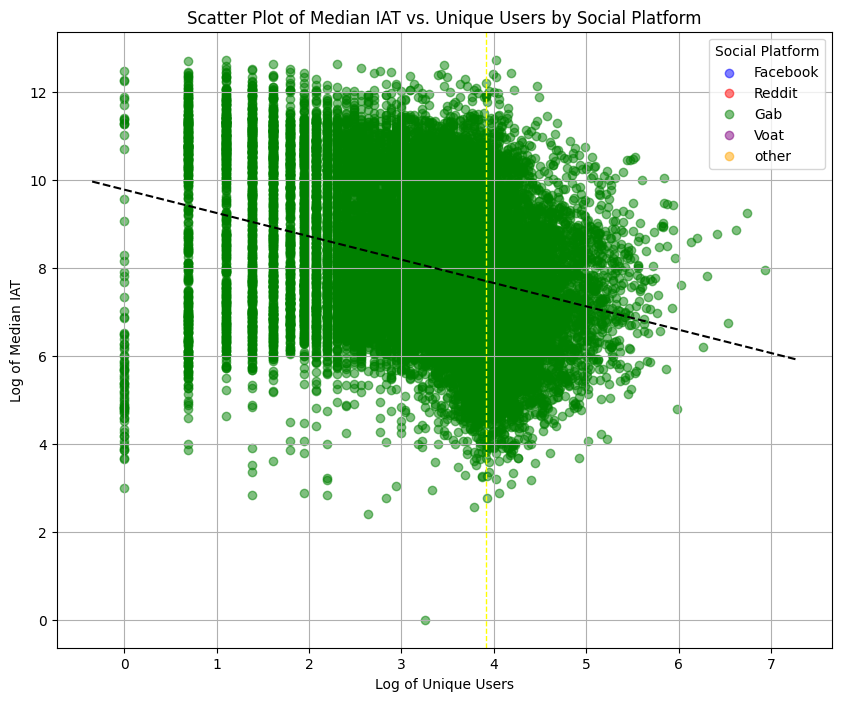

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Concatenate the data
df = gb#pd.concat(datas)

# Calculate the median of 'IAT_user_thread' per 'post_id' and 'user_id'
median_IAT = df.groupby(['post_id', 'user_id'])['IAT_user_thread'].max().reset_index()
median_IAT = median_IAT.groupby('post_id')['IAT_user_thread'].median().reset_index()
median_IAT.columns = ['post_id', 'Median_IAT']

# Calculate the number of unique 'user_id' per 'post_id'
unique_users = df.groupby('post_id')['user_id'].nunique().reset_index()
unique_users.columns = ['post_id', 'Unique_Users']

# Merge the two resulting DataFrames
merged = pd.merge(median_IAT, unique_users, on='post_id')

# Merge with the social column
social_data = df[['post_id', 'social']].drop_duplicates()
merged = pd.merge(merged, social_data, on='post_id')

# Log-transform the data
merged['Log_Unique_Users'] = np.log(merged['Unique_Users'])
merged['Log_Median_IAT'] = np.log(merged['Median_IAT'])

# Prepare data for linear regression
merged = merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['Log_Unique_Users', 'Log_Median_IAT'])
X = merged[['Log_Unique_Users']].values
y = merged['Log_Median_IAT'].values

# Fit the linear regression model
reg = LinearRegression().fit(X, y)


# Create a scatter plot
plt.figure(figsize=(10, 8))

# Map social platforms to colors
colors = {'Facebook': 'blue', 'Reddit': 'red', 'Gab': 'green', 'Voat': 'purple', 'other': 'orange'}

for social, color in colors.items():
    subset = merged[merged['social'] == social]
    plt.scatter(subset['Log_Unique_Users'], subset['Log_Median_IAT'], color=color, label=social, alpha=0.5, marker='o')

# Plot the regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = reg.intercept_ + reg.coef_ * x_vals
plt.plot(x_vals, y_vals, '--', color='black')

# Add a vertical line at log(55)
plt.axvline(x=np.log(50), color='yellow', linestyle='--', linewidth=1)

plt.title('Scatter Plot of Median IAT vs. Unique Users by Social Platform')
plt.xlabel('Log of Unique Users')
plt.ylabel('Log of Median IAT')
plt.legend(title='Social Platform')
plt.grid(True)
plt.show()
